# Basic python imports and model settings

In [1]:
import underworld.visualisation as vis

from underworld import function as fn
import underworld as uw

import matplotlib.pyplot as pyplot
import numpy as np
from scipy.spatial import distance

import math
import os

import time as ti

# details of the bottom curve
# details of the bottom curve
L = [160, 80, 40, 20, 10, 5]
i = 2
maxX = L[i] * 1000.
min_bed_height = 0.           # we want exactly 0 m of rock beneath the ice

maxY = 1000.

omega = 2. * np.pi / maxX
alpha = 0.1 / 360. * np.pi

beta_square = 1000. + 1000. * fn.math.sin(omega * fn.input()[0]) + 1e-18
As = 1. / beta_square
tau_b = maxY * np.sin(alpha) * 9.81 * 910.

A = 1e-16
n = 3.

resY = 20
resX = int(resY * maxX / maxY)

resY = 250
resX = 500

resY = 50
resX = 100

print("resX: " + str(resX) + " resY: " + str(resY))

# generate output path
outputPath = os.path.join(os.path.abspath("."), "output/")
if not os.path.exists(outputPath):
    os.makedirs(outputPath)

delta_timestep = 1.						# in years, used in the main loop
# after how many timesteps do we need new figures?
update_figures_after_n_timesteps = 1
number_of_deformation_lines = 11

number_of_deformation_points = 50000
distance_between_deformation_lines = maxY / (number_of_deformation_lines + 1)

resX: 100 resY: 50


# Mesh + mesh variables

In [2]:
elementType = "Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian(elementType=(elementType),
                                elementRes=(resX, resY),
                                minCoord=(0., 0.),
                                maxCoord=(maxX, maxY),
                                periodic=[True, False])

submesh = mesh.subMesh

# save the mesh
# mesh.save(outputPath + "mesh.h5")

velocityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=mesh.dim)
pressureField = uw.mesh.MeshVariable(mesh=mesh.subMesh, nodeDofCount=1)

viscosityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)

materialField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)

strainRateField = mesh.add_variable(1)
basalVelocityField = mesh.add_variable(1)

pressureField.data[:] = 0.
velocityField.data[:] = [0., 0.]
materialField.data[:] = [0]
basalVelocityField.data[:] = tau_b / beta_square.evaluate(mesh.data)

# Initialise the 'materialVariable' data to represent different materials.
materialA = 0  	# accommodation layer, a.k.a. Sticky Air
materialV = 1  	# ice, isotropic
materialR = 2   # rock
materialT = 5   # test material in order to test eg interface detection


# Define the ice-air and ice-rock interface

(which are just the min/max coordinates in this experiment, but I'll keep the commented-out Exp-B version as reference and for more flexibility)

In [3]:
iceRockInterfaceSet = mesh.add_variable(1)
iceAirInterfaceSet = mesh.add_variable(1)

iceRockInterfaceSet.data[:] = False
iceAirInterfaceSet.data[:] = False

botSet = mesh.specialSets['Bottom_VertexSet']
topSet = mesh.specialSets['Top_VertexSet']

iceRockInterfaceSet.data[topSet] = True
iceAirInterfaceSet.data[botSet] = True

# Swarm

In [4]:
part_per_cell = 50
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout(
    swarm=swarm, particlesPerCell=part_per_cell)
swarm.populate_using_layout(layout=swarmLayout)

surfaceSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
deformationSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

# create pop control object
pop_control1 = uw.swarm.PopulationControl(swarm, aggressive=True, particlesPerCell=part_per_cell)
pop_control2 = uw.swarm.PopulationControl(surfaceSwarm)
pop_control3 = uw.swarm.PopulationControl(deformationSwarm)

# ### Create a particle advection system
#
# Note that we need to set up one advector system for each particle swarm (our global swarm and a separate one if we add passive tracers).
advector1 = uw.systems.SwarmAdvector(swarm=swarm,velocityField=velocityField, order=2)
advector2 = uw.systems.SwarmAdvector(swarm=surfaceSwarm,     velocityField=velocityField, order=2)
advector3 = uw.systems.SwarmAdvector(swarm=deformationSwarm, velocityField=velocityField, order=2)

# Tracking different materials

materialVariable = swarm.add_variable(dataType="int", count=1)

# passive markers at the surface are inserted whenever 100 m of new snow hav been created in the main loop
deformationPoints = np.array(np.meshgrid(np.linspace(0., maxX, int(
    number_of_deformation_points)), np.linspace(0., maxY, number_of_deformation_lines))).T.reshape(-1, 2)
deformationSwarm.add_particles_with_coordinates(deformationPoints)

surfacePoints = np.zeros((int(number_of_deformation_points), 2))
surfacePoints[:, 0] = np.linspace(0., maxX, int(number_of_deformation_points))
surfacePoints[:, 1] = maxY
surfaceSwarm.add_particles_with_coordinates(surfacePoints)

particleDensity = swarm.add_variable(dataType="double", count=1)
particleDensity.data[:] = 0.0

materialVariable.data[:] = materialV

# Functions

In [5]:
help(uw.function.tensor)

Help on module underworld.function.tensor in underworld.function:

NAME
    underworld.function.tensor - This module provides functions relating to tensor operations.

DESCRIPTION
    All Underworld2 functions return 1d array type objects. For tensor objects, 
    the following convention is used:
    
    Full tensors:
    
    2D:
        .. math::
            \left[  a_{00}, a_{01}, \\
                        a_{10},     a_{11}  \right]
    3D:
        .. math::
            \left[  a_{00}, a_{01}, a_{02}, \\
                        a_{10},     a_{11}, a_{12}, \\
                        a_{20}, a_{21}, a_{22}  \right]
                    
    Symmetric tensors:
    
    2D:
        .. math::
            \left[  a_{00}, a_{11}, a_{01}  \right]
    3D:
        .. math::
            \left[  a_{00}, a_{11}, a_{22}, a_{01}, a_{02}, a_{12}  \right]

CLASSES
    underworld.function._function.Function(underworld._stgermain.LeftOverParamsChecker)
        antisymmetric
        deviatoric
     

$$
\left[  a_{00}, a_{01}, \\
        a_{10},     a_{11}  \right]
$$

In [5]:
strainRateTensor = fn.tensor.symmetric(velocityField.fn_gradient)
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateTensor)

minViscosityIceFn = fn.misc.constant(1e+10 / 3.1536e7)
maxViscosityIceFn = fn.misc.constant(1e+15 / 3.1536e7)

viscosityFnAir = fn.misc.constant(1e6 / 3.1536e7)
viscosityFnRock = fn.misc.constant(1e22 / 3.1536e7)

viscosityFnIceBase = 0.5 * A ** (-1./n) * (strainRate_2ndInvariantFn**((1.-n) / n))
viscosityFnIce = fn.misc.max(fn.misc.min(viscosityFnIceBase, maxViscosityIceFn), minViscosityIceFn)

viscosityMap = {
                materialV: viscosityFnIce,
                materialA: viscosityFnAir,
                materialR: viscosityFnRock,
               }

viscosityFn = fn.branching.map( fn_key=materialVariable, mapping=viscosityMap )

logViscosityFn = fn.math.log10( fn.misc.max( fn.misc.min( viscosityFnIceBase, viscosityFnRock ), viscosityFnAir ) )

devStressFn = 2.0 * viscosityFn * strainRateTensor
shearStressFn = strainRate_2ndInvariantFn * viscosityFn * 2.0

densityFnAir = fn.misc.constant( 0. )
densityFnIce = fn.misc.constant( 910. )
densityFnRock = fn.misc.constant( 2700. )

densityMap = {
                materialA: densityFnAir,
                materialV: densityFnIce,
                materialR: densityFnRock
             }

densityFn = fn.branching.map(fn_key=materialVariable, mapping=densityMap)

#particleDensity.data[:] = densityFn.evaluate(swarm)

particleDensity.data[:] = 910.

surf_inclination = 0.1 * np.pi / 180. # 0.1 = Experiment D, 0.5 = Experiment B
#surf_inclination = 0.
z_hat = (math.sin(surf_inclination), - math.cos(surf_inclination))

buoyancyFn = densityFn * z_hat * 9.81

# Solver and boundary conditions

In [6]:
''' 
# 3.a  Create the Dirichlet Condition
botSet = mesh.specialSets['Bottom_VertexSet']
topSet = mesh.specialSets[   'Top_VertexSet']
totSet = botSet + topSet
sidewalls = mesh.specialSets['Left_VertexSet'] + mesh.specialSets['Right_VertexSet']

cond_dirichlet = uw.conditions.DirichletCondition(tempField,sidewalls)
tempField.data[botSet] = 373.
tempField.data[topSet] = 273.
# 3.b  Create the Neumann condition
#      Create this constant value function explicitly so we can
#      modify it later. 
flux = uw.function.Function.convert(0.)
cond_neumann = uw.conditions.NeumannCondition(tempField,totSet,flux)

# 4.  Diffusivity
alpha = 1. 

# 5.  Create the required system.
heatSys = uw.systems.SteadyStateHeat(temperatureField=tempField, 
                                     fn_diffusivity=alpha, 
                                     conditions=[cond_dirichlet,cond_neumann])


'''


iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
base = mesh.specialSets["MinJ_VertexSet"]
top = mesh.specialSets["MaxJ_VertexSet"]

velocityField.data[:] = [0., 0.]

botSet = mesh.specialSets['Bottom_VertexSet']
topSet = mesh.specialSets['Top_VertexSet']
leftSet = mesh.specialSets['Left_VertexSet']
rightSet = mesh.specialSets['Right_VertexSet']

### Dirichlet
condition1 = uw.conditions.DirichletCondition(variable=velocityField,indexSetsPerDof=(botSet, botSet))

velocityField.data[:] = [0., 0.]
velocityField.data[botSet] = basalVelocityField.data[botSet]


### Neumann
velocityFn = shearStressFn / beta_square
velocityField.data[:] = [0., 0.]
grad = (1000. * omega * fn.math.cos(omega*fn.input()[0]), 0.)
condition2 = uw.conditions.NeumannCondition(velocityField,(botSet, botSet),grad)

stokes = uw.systems.Stokes(
    velocityField=velocityField,
    pressureField=pressureField,
    voronoi_swarm=swarm,
    conditions=[
            condition2,
            ],
    fn_viscosity=viscosityFn,
    fn_bodyforce=buoyancyFn,
)

solver = uw.systems.Solver(stokes)

# solver.set_inner_method("lu")
solver.set_inner_method("superlu")
# solver.set_inner_method("mumps")

# solver.set_penalty(1.0e10)  # higher penalty = larger stability
# solver.options.scr.ksp_rtol = 1.0e-3

surfaceArea = uw.utils.Integral( fn=1.0, mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral( fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=top)

def calibrate_pressure():

    global pressureField
    global surfaceArea
    global surfacePressureIntegral

    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate() 
    pressureField.data[:] -= p0 / area

    print (f'Calibration pressure {p0 / area}')

# test it out
try:
    nl_tol = 1e-2
    # nl_tol = 5.e-3
    solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
    # solver.solve(nonLinearIterate=True, callback_post_solve=calibrate_pressure)
    solver.print_stats()
except:
    print("Solver died early..")
    exit(0)

Calibration pressure 35515.28027782115
Calibration pressure 26751864.063352488
Calibration pressure -32202033.33344585
Calibration pressure 452482.6475870448
Calibration pressure -346534.90270926064
Calibration pressure -9974.438590245652
Calibration pressure 153355.30256654794
Calibration pressure 6650.09116731042
Calibration pressure 41477.67451128979
Calibration pressure -38516.43641520023
Calibration pressure -588064.0508647005
Calibration pressure -232750.17348886048
Calibration pressure 39900.17908434045
Calibration pressure -336428.9467731446

 
Pressure iterations: 434
Velocity iterations:   1 (presolve)      
Velocity iterations: 448 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations: 450 (total solve)   
 
SCR RHS  setup time: 3.6714e-01
SCR RHS  solve time: 8.1491e-03
Pressure setup time: 3.4428e-04
Pressure solve time: 2.4282e+00
Velocity setup time: 2.3842e-07 (backsolve)
Velocity solve time: 5.0762e-03 (backsolve)
Total solve time   : 2.8117e+0

In [ ]:
#print(mesh.data[i])

for i in mesh.data[botSet]:
    
    print(shearStressFn.evaluate([i[0], i[1]]) * As.evaluate([i[0], i[1]]))
    
    # print( As.evaluate(mesh[botSet]) )
    # velocityField.data[i] = 
    
#for index, coord in enumerate(mesh.data[botSet]):
    #print(velocityField.data[i][0]) = As.evaluate(mesh.data[i])
    
# test it out
try:
    nl_tol = 1e-2
    # nl_tol = 5.e-3
#    solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
    # solver.solve(nonLinearIterate=True, callback_post_solve=calibrate_pressure)
    solver.print_stats()
except:
    print("Solver died early..")
    exit(0)

In [ ]:
print(mesh.data[botSet])
strainRate_2ndInvariantFn

In [ ]:
x = np.linspace(0., 40000., 1000)

#pyplot.plot(910. * 9.81 * 1000. * np.sin (0.1 / 180 * np.pi) / (np.sin(x * omega) * 1000. + 1000.) + 1e-18)
#pyplot.ylim((0,50))

#print( viscosityFn.evaluate(mesh.data[botSet])[:,0] )
#print( strainRateTensor.evaluate(mesh)[:,1] )

#pyplot.plot(strainRateTensor.evaluate(mesh.data[botSet])[:,1] * viscosityFn.evaluate(mesh.data[botSet])[:,0] * 2.0)
#pyplot.plot(strainRateTensor.evaluate(mesh.data[botSet])[:,1])
#pyplot.plot(strainRateTensor.evaluate(mesh.data[botSet])[:,2])
#pyplot.plot(strainRate_2ndInvariantFn.evaluate(mesh.data[topSet]))

pyplot.plot(velocityField.evaluate(mesh.data[topSet])[:,1])

# Output

0.0,1000.0,109242823.087,109137468.213



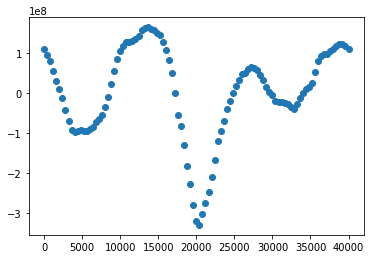

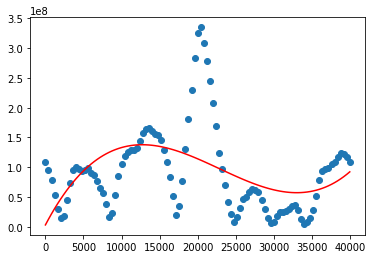

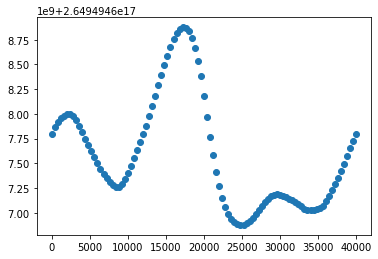

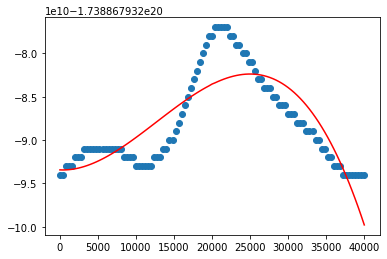

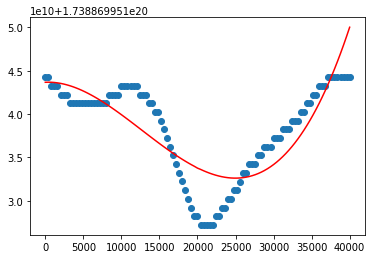

In [7]:
meshCorrectedPressure = mesh.add_variable( 1 )
projectorCorrectedPressure = uw.utils.MeshVariable_Projection( meshCorrectedPressure, pressureField, type=0 )
projectorCorrectedPressure.solve()

meshShearStress = mesh.add_variable( 1 )
projectorShearStress = uw.utils.MeshVariable_Projection( meshShearStress, shearStressFn, type=0 )
projectorShearStress.solve()

outputFile = os.path.join(os.path.abspath("."), "output_step_ice_rock_0.csv")

with open(outputFile, "w") as text_file:

    text_file.write("X, " + "Y, " + "P, " + "diff, " + "\n")

    # sort in ascending order based on the x-position of the data ('left to right')
    l = np.where(iceRockInterfaceSet.data[:])[0]
    inds = mesh.data[l,0].argsort()
    l = l[inds]

    for i in l:
        textline = str(mesh.data[i][0] ) + \
            "," + str(mesh.data[i][1] ) + \
            "," + str(meshCorrectedPressure.data[i][0]) + \
            "," + str(meshShearStress.data[i][0]) + \
            "\n"
        text_file.write(textline)
        
outputFile = os.path.join(os.path.abspath("."), "output_step_ice_air_0.csv")

with open(outputFile, "w") as text_file:

    text_file.write("X, " + "Y, " + "Vx, " + "Vy, " + "\n")

    # sort in ascending order based on the x-position of the data ('left to right')
    l = np.where(iceAirInterfaceSet.data[:])[0]
    inds = mesh.data[l,0].argsort()
    l = l[inds]

    for i in l:
        textline = str(mesh.data[i][0] ) + \
            "," + str(mesh.data[i][1] ) + \
            "," + str(velocityField.data[i][0]) + \
            "," + str(velocityField.data[i][1]) + \
            "\n"
        text_file.write(textline)

#---------------------------------------------
        
from scipy.signal import savgol_filter

outputFile = "output_step_ice_rock_0.csv"

with open (outputFile) as file:
    line = file.readlines()[1]
    print (line)

a = np.loadtxt(open(outputFile, "rb"), delimiter=",", skiprows=1)
a = a.T

pyplot.scatter (a[0], a[2])
pyplot.show()

pyplot.scatter (a[0], a[3])
yhat = savgol_filter(a[3], 101, 3)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

#---------------------------------------------

outputFile = "output_step_ice_air_0.csv"
a = np.loadtxt(open(outputFile, "rb"), delimiter=",", skiprows=1)
a = a.T

pyplot.scatter (a[0], a[2])
pyplot.show()

pyplot.scatter (a[0], a[3])
yhat = savgol_filter(a[3], 101, 3)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

pyplot.scatter (a[0], np.sqrt(a[3]**2 + a[2]**2))
yhat = savgol_filter(np.sqrt(a[3]**2 + a[2]**2), 101, 3)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()
        

## Test the traction field

## Figures


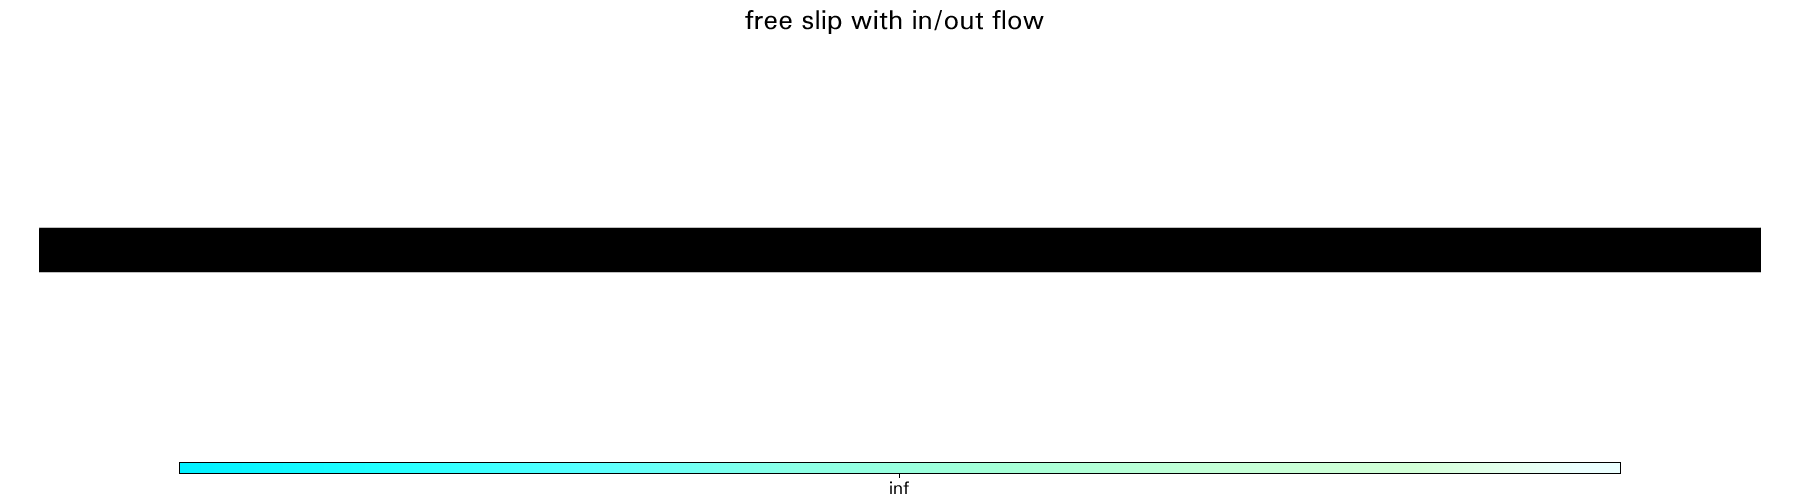


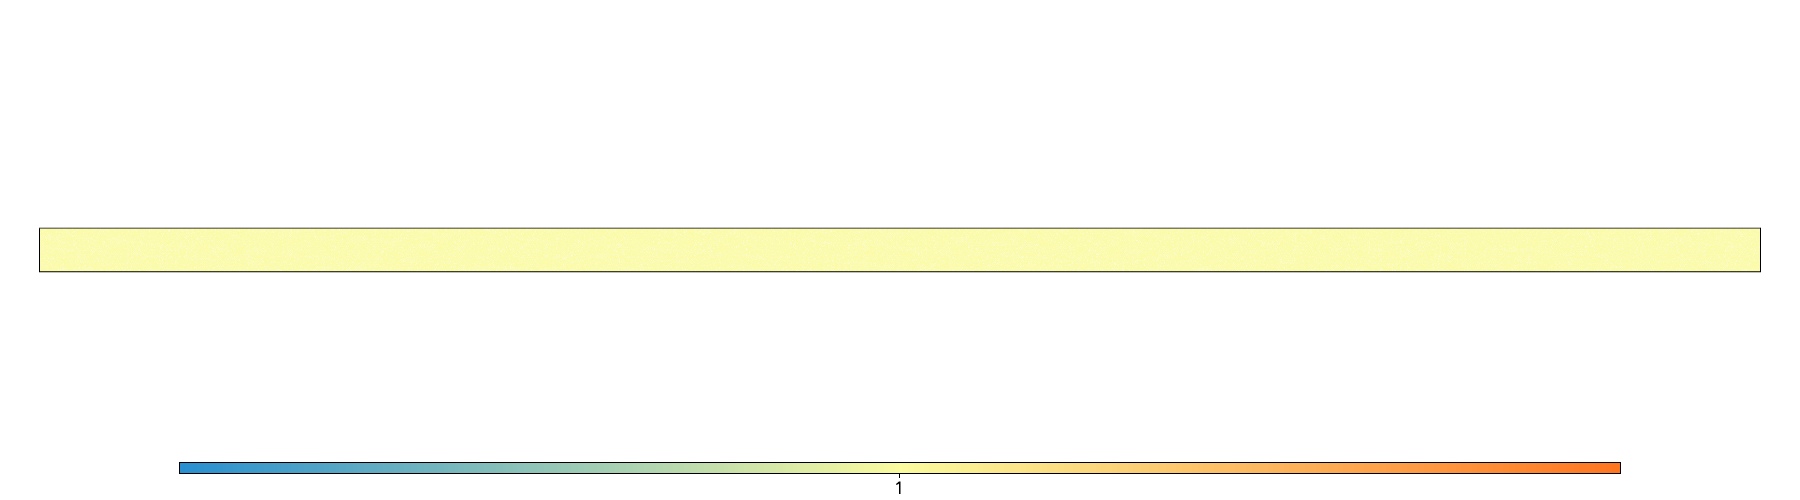


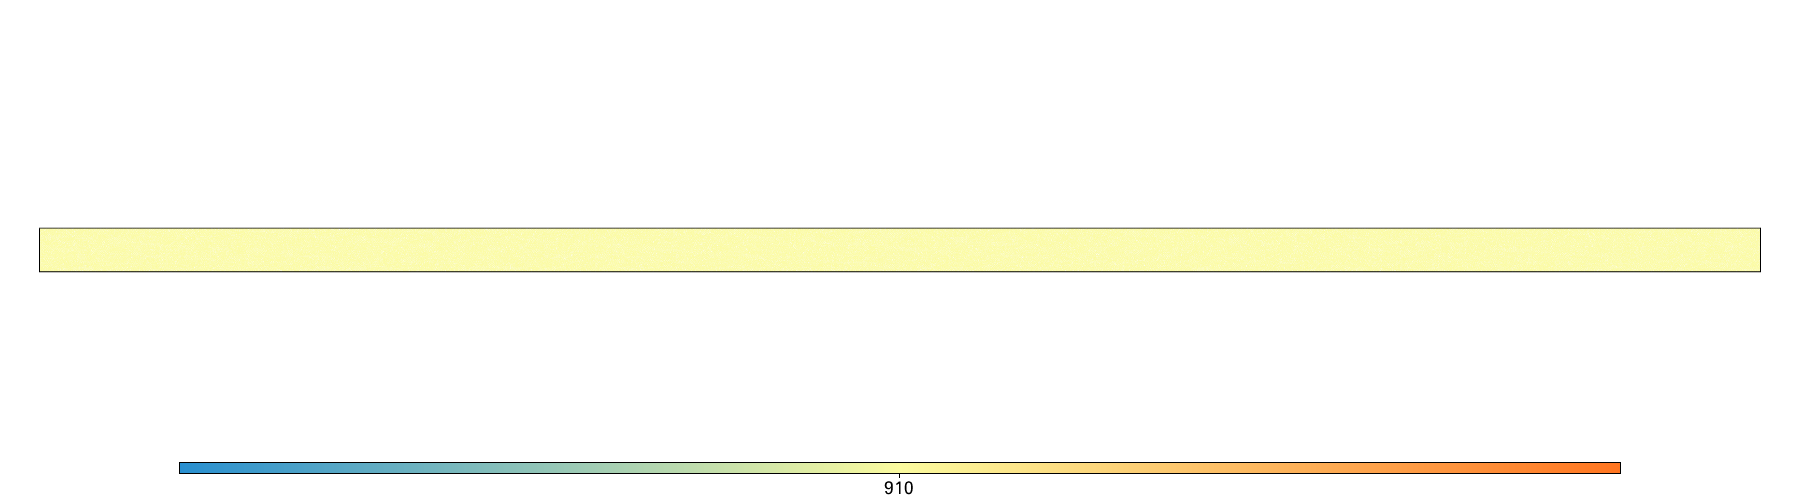

basal velocity



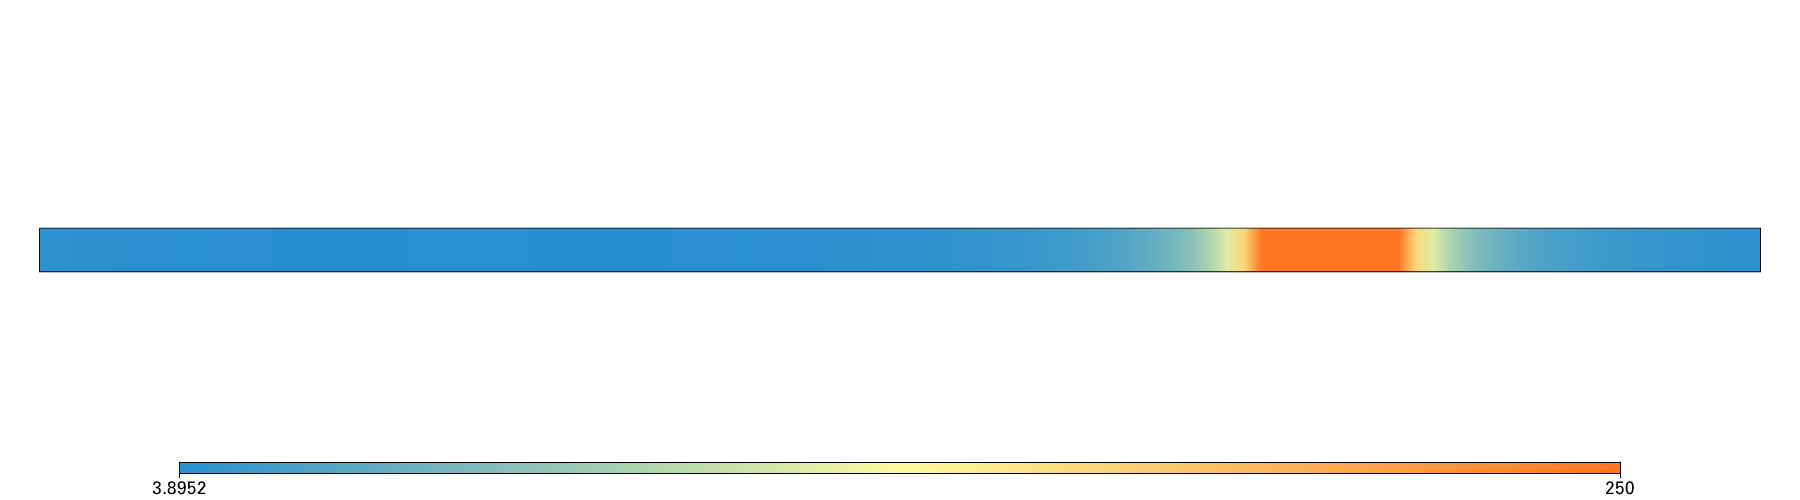


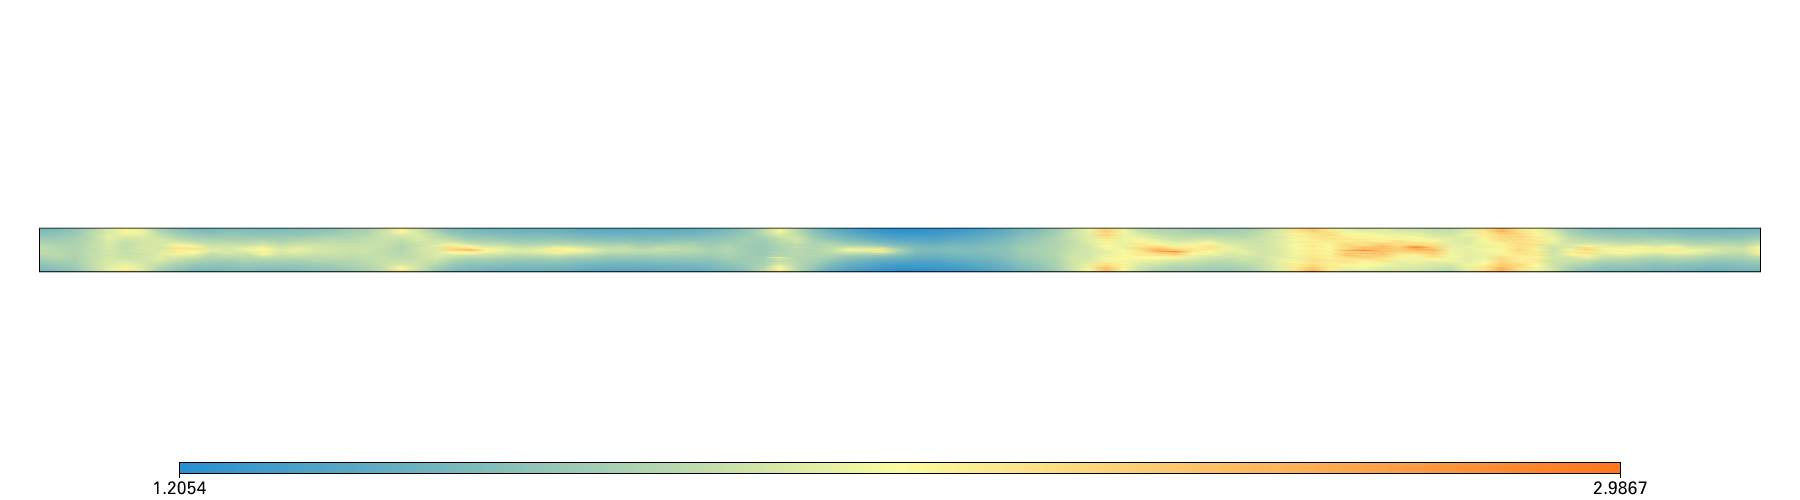


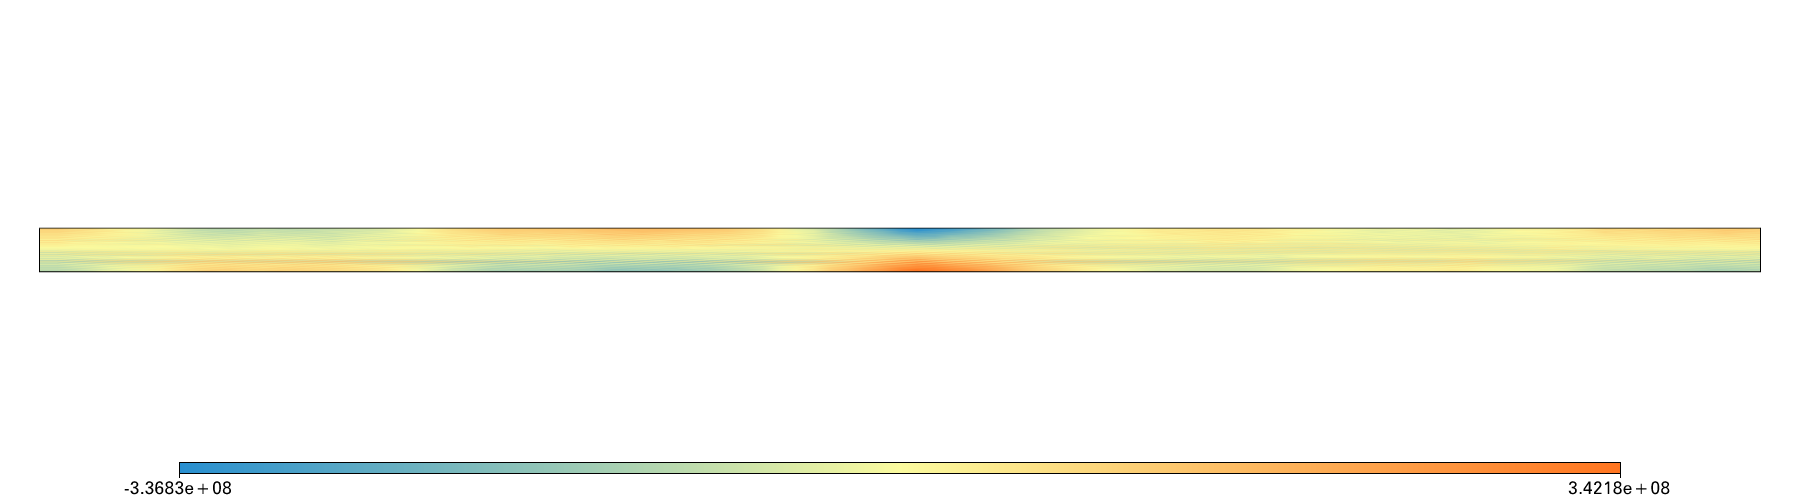

'\nfigCorrectedPressure = vis.Figure(figsize=(1800, 500))\nfigCorrectedPressure.append( vis.objects.Surface(mesh, meshCorrectedPressure) )\nfigCorrectedPressure.show()\n\nfigMeshShearStressCorrected = vis.Figure(figsize=(1800, 500))\nfigMeshShearStressCorrected.append( vis.objects.Surface(mesh, meshShearStress) )\nfigMeshShearStressCorrected.show()\n#figMeshStress.save_image("meshStress.png")\n\nfigHorShearStress = vis.Figure(figsize=(1800, 500))\nfigHorShearStress.append(vis.objects.Surface(mesh, devStressFn[2]) )\nfigHorShearStress.show()\n#figHorShearStress.save_image("horShearStress.png")\n'

In [8]:
figinflow = vis.Figure(figsize=(1800,500), title="free slip with in/out flow")
figinflow.append(vis.objects.VectorArrows(mesh, velocityField))
figinflow.append(vis.objects.Surface(mesh, uw.function.math.dot(velocityField,velocityField), colours="gebco"))
vis.Figure.show_grid([figinflow])

figMaterial = vis.Figure(figsize=(1800, 500))
figMaterial.append(vis.objects.Points( swarm, materialVariable, pointSize=1.0))
figMaterial.show()
#figMaterial.save_image("material.png")

figDensity = vis.Figure(figsize=(1800, 500))
figDensity.append(vis.objects.Points( swarm, particleDensity, pointSize=1.0))
figDensity.show()
#figDensity.save_image("density.png")

print ('basal velocity')
figBV = vis.Figure(figsize=(1800, 500))
figBV.append(vis.objects.Surface(mesh, fn.misc.min(250.0,basalVelocityField)))
figBV.show()

figViscosity = vis.Figure(figsize=(1800, 500))
figViscosity.append(vis.objects.Surface(mesh, logViscosityFn))
figViscosity.show()
#figViscosity.save_image("logviscosity.png")

figPressure = vis.Figure(figsize=(1800, 500))
figPressure.append(vis.objects.Surface(mesh, pressureField))
figPressure.show()
#figPressure.save_image("pressure.png")

'''
figCorrectedPressure = vis.Figure(figsize=(1800, 500))
figCorrectedPressure.append( vis.objects.Surface(mesh, meshCorrectedPressure) )
figCorrectedPressure.show()

figMeshShearStressCorrected = vis.Figure(figsize=(1800, 500))
figMeshShearStressCorrected.append( vis.objects.Surface(mesh, meshShearStress) )
figMeshShearStressCorrected.show()
#figMeshStress.save_image("meshStress.png")

figHorShearStress = vis.Figure(figsize=(1800, 500))
figHorShearStress.append(vis.objects.Surface(mesh, devStressFn[2]) )
figHorShearStress.show()
#figHorShearStress.save_image("horShearStress.png")
'''

# Functions

In [ ]:
# The stress is only guaranteed to be accurate when integrated across an element. Fluctuations
# within an element can be significant. Mapping to the mesh can help

def update_advection_diffusion(t):

    global meshV, maxX, maxY, snowfall_rate, nl_tol
    global calibrate_pressure

    tin = t

    while t > 0.:
    
        #solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
        solver.solve(nonLinearIterate=True, callback_post_solve=calibrate_pressure)
        
        # Retrieve the maximum possible timestep for the advection system.
        dt = min([advector1.get_max_dt(), advector2.get_max_dt(), advector3.get_max_dt(), advDiff.get_max_dt()])
        
        if dt > t:
            dt = t
            t = 0.
        else:
            t = t - dt
            
        advDiff.integrate(dt)
        advector1.integrate(dt)
        #advector2.integrate(dt)
        advector3.integrate(dt) # the deformation swarm
        
        # particle population control
        pop_control1.repopulate()
        #pop_control2.repopulate()
        #pop_control3.repopulate()
        
        particleTemperature.data[:] = temperatureField.evaluate(swarm)
        particleDensity.data[:] = densityFn.evaluate(swarm)
        
        # c_axis_rotation(dt)

    return time+tin

def update_infinite_flow(t):
    
    """
    In order for infinite flow to work you need to
    a) use the same medication as MC Escher,
    b)	1) generate 'inclination' --> z_hat definition
        2) activate wrapping by setting 'periodic = [True, False]' during the mesh creation
    """
    
    global meshV, maxX, maxY, snowfall_rate, nl_tol
    global calibrate_pressure
    
    tin = t
    
    while t:
        
        #solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
        solver.solve(nonLinearIterate=True, callback_post_solve=calibrate_pressure)
        
        # Retrieve the maximum possible timestep for the advection system.
        dt = min([advector1.get_max_dt(), advector3.get_max_dt()])
        
        print(f'---------------------{dt}')
        #exit(0)
        
        if dt > t:
            dt = t
            t = 0.
        else:
            t = t - dt
            
        print (t)
        
        # Advect using this timestep size.
        advector1.integrate(dt) # the swarm
        #advector2.integrate(dt)# the surface swarm
        advector3.integrate(dt) # the deformation swarm
        
        # particle population control
        # not sure, if this is really necessary. it is _not_ in the standard advecton code, but only if there is a mesh-deformation involved. my hope would be that this command will not allow underresolved cells
        pop_control1.repopulate()
        #pop_control2.repopulate()
        #pop_control3.repopulate()
        
        # c_axis_rotation(dt)

    return time+tin

# Main function

In [ ]:
def main():
    
    # generate output file
    
    outputFile = os.path.join(os.path.abspath("."), "output.csv")
    if os.path.exists(outputFile):
        os.rename(outputFile, outputFile + ".bkp")
    
        
    # Stepping. Initialise time and timestep.
    
    global time, step
    time = 0.
    step = 0
    nsteps = 11
    
    while step < nsteps:
        
        delta_timestep = 1.
        
        if step == 0:      
            # solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
            solver.solve(nonLinearIterate=True, callback_post_solve=calibrate_pressure)
        
        projectorCorrectedPressure.solve()
        projectorShearStress.solve()

        outputFile = os.path.join(os.path.abspath("."), "output_step_ice_rock_" + str(step) + ".csv")

        with open(outputFile, "w") as text_file:

            text_file.write("X, " + "Y, " + "P, " + "diff, " + "\n")

            # sort in ascending order based on the x-position of the data ('left to right')
            l = np.where(iceRockInterfaceSet.data[:])[0]
            inds = mesh.data[l,0].argsort()
            l = l[inds]

            for i in l:
                textline = str(mesh.data[i][0] ) + \
                    "," + str(mesh.data[i][1] ) + \
                    "," + str(meshCorrectedPressure.data[i][0]) + \
                    "," + str(meshShearStress.data[i][0]) + \
                    "\n"
                text_file.write(textline)

        outputFile = os.path.join(os.path.abspath("."), "output_step_ice_air_" + str(step) + ".csv")

        with open(outputFile, "w") as text_file:

            text_file.write("X, " + "Y, " + "Vx, " + "Vy, " + "\n")

            # sort in ascending order based on the x-position of the data ('left to right')
            l = np.where(iceAirInterfaceSet.data[:])[0]
            inds = mesh.data[l,0].argsort()
            l = l[inds]

            for i in l:
                textline = str(mesh.data[i][0] ) + \
                    "," + str(mesh.data[i][1] ) + \
                    "," + str(velocityField.data[i][0]) + \
                    "," + str(velocityField.data[i][1]) + \
                    "\n"
                text_file.write(textline)
        
        if (step % 1 == 0):
            
            projectorCorrectedPressure.solve()
            projectorShearStress.solve()
            
            figMaterial.save_image( outputPath + "material-" + str(step).zfill(4) + " - " + str(time) + ".png")
            figDensity.save_image( outputPath + "density-" + str(step).zfill(4) + " - " + str(time) + ".png")
            figViscosity.save_image( outputPath + "viscosity-" + str(step).zfill(4) + " - " + str(time) + ".png")
            figPressure.save_image( outputPath + "pressure-" + str(step).zfill(4) + " - " + str(time) + ".png")
            figCorrectedPressure.save_image( outputPath + "pressureCorrected-" + str(step).zfill(4) + " - " + str(time) + ".png")
            figMeshShearStressCorrected.save_image( outputPath + "shearStressCorrected-" + str(step).zfill(4) + " - " + str(time) + ".png")
            figHorShearStress.save_image( outputPath + "horShearStress-" + str(step).zfill(4) + " - " + str(time) + ".png")

        print (f'Finished timestep: {step}')
        
        time = update_infinite_flow(t=delta_timestep)
        step += 1

if __name__ == "__main__":
    main()

In [ ]:
from scipy.signal import savgol_filter

outputFile = "output_step_ice_rock_0.csv"

with open (outputFile) as file:
    line = file.readlines()[1]
    print (line)

a = np.loadtxt(open(outputFile, "rb"), delimiter=",", skiprows=1)
a = a.T

pyplot.scatter (a[0], a[1])
pyplot.show()

pyplot.scatter (a[0], a[2])
yhat = savgol_filter(a[2], 101, 3)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

#---------------------------------------------

outputFile = "output_step_ice_air_0.csv"
a = np.loadtxt(open(outputFile, "rb"), delimiter=",", skiprows=1)
a = a.T

pyplot.scatter (a[0], a[1])
pyplot.show()

pyplot.scatter (a[0], a[2])
yhat = savgol_filter(a[2], 101, 3)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

pyplot.scatter (a[0], np.sqrt(a[2]**2 + a[1]**2))
#yhat = savgol_filter(a[2], 101, 3)
#pyplot.plot(a[0], yhat, color='red')
pyplot.show()